In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nandeeshhu_pancrease_ct_segmenatation_path = kagglehub.dataset_download('nandeeshhu/pancrease-ct-segmenatation')

print('Data source import complete.')


Data source import complete.


In [ ]:
nandeeshhu_pancrease_ct_segmenatation_path

'/kaggle/input/pancrease-ct-segmenatation'

In [ ]:
ls - /kaggle/input/pancrease-ct-segmenatation

ls: cannot access '-': No such file or directory
/kaggle/input/pancrease-ct-segmenatation:
images/  masks/


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from PIL import Image

# Paths
image_dir = "/kaggle/input/pancrease-ct-segmenatation/images"
mask_dir = "/kaggle/input/pancrease-ct-segmenatation/masks"

# Function to load all images and masks with sampling
def load_images_and_masks(image_dir, mask_dir, negative_ratio=0.15):
    X = []
    Y = []

    for category in ['negative', 'positive']:
        image_paths = sorted(glob.glob(os.path.join(image_dir, category, "*.png")))
        mask_paths = sorted(glob.glob(os.path.join(mask_dir, category, "*.png")))

        # Apply sampling only to negative category
        if category == 'negative':
            sample_size = int(len(image_paths) * negative_ratio)
            image_paths = image_paths[:sample_size]
            mask_paths = mask_paths[:sample_size]

        # No sampling needed for positive category
        for img_path, mask_path in zip(image_paths, mask_paths):
            X.append(img_path)
            Y.append(mask_path)

    return X, Y

# Function to load an image and its corresponding mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Read as grayscale image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Read as grayscale mask
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask

    return image, mask

# Function to create TensorFlow dataset from image paths
def create_tf_dataset(image_paths, mask_paths, batch_size=8):
    # Create a dataset of image and mask pairs
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img_path, mask_path: load_image_and_mask(img_path, mask_path), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Load the data
X_paths, Y_paths = load_images_and_masks(image_dir, mask_dir, negative_ratio=0.15)

# Create the dataset
batch_size = 8
dataset = create_tf_dataset(X_paths, Y_paths, batch_size=batch_size)

# Inspect the dataset shape by iterating through one batch
for images, masks in dataset.take(1):
    print("Batch of images shape:", images.shape)
    print("Batch of masks shape:", masks.shape)


Batch of images shape: (8, 512, 512, 1)
Batch of masks shape: (8, 512, 512, 1)


In [ ]:
len(X_paths)

8691

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(512, 512, 1)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bridge
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# Instantiate model
model = unet_model()

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Optional: Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("unet_model.keras", save_best_only=True)
]

# Train the model
model.fit(dataset, epochs=1, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, None, None, 1))
  warnings.warn(msg)


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1923s 2s/step - accuracy: 0.9969 - loss: 367267616.0000


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 512, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


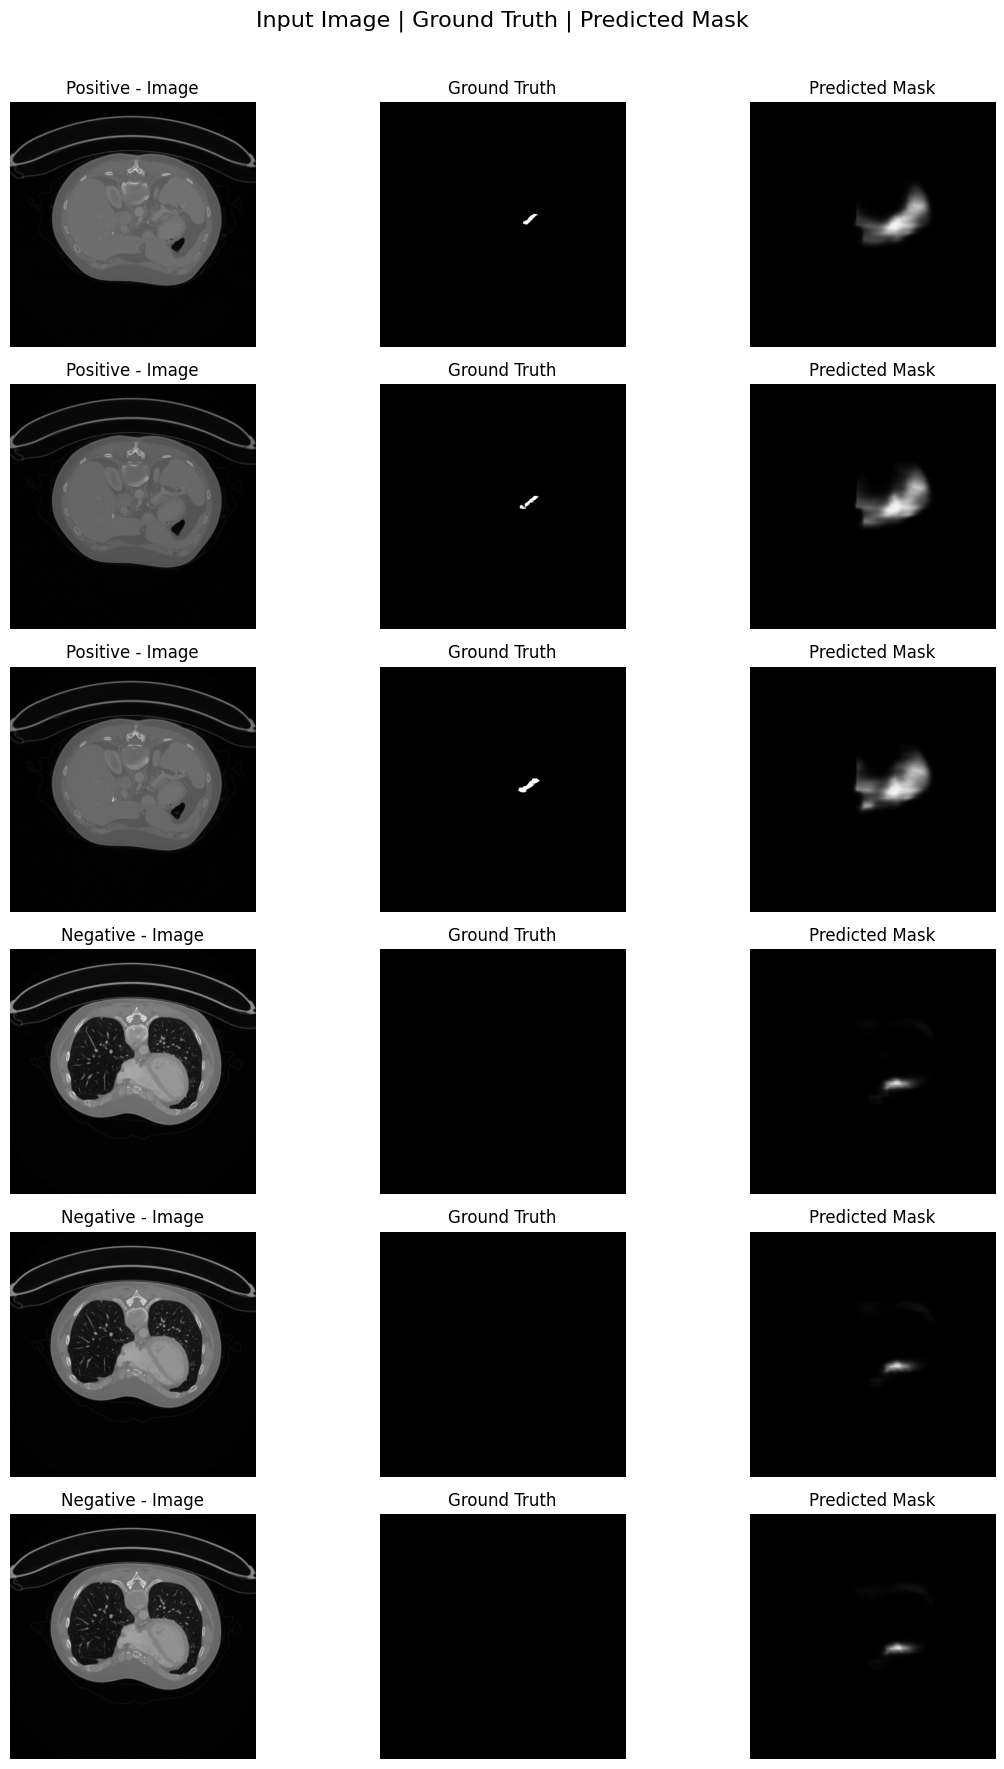

In [ ]:
import matplotlib.pyplot as plt

# Separate positive and negative paths
def get_separate_samples(image_dir, mask_dir, num_samples=3):
    samples = {'positive': [], 'negative': []}
    for category in ['positive', 'negative']:
        image_paths = sorted(glob.glob(os.path.join(image_dir, category, "*.png")))[:num_samples]
        mask_paths = sorted(glob.glob(os.path.join(mask_dir, category, "*.png")))[:num_samples]
        samples[category] = list(zip(image_paths, mask_paths))
    return samples

# Load and predict for each sample
def plot_predictions(samples):
    fig, axes = plt.subplots(6, 3, figsize=(12, 18))
    fig.suptitle("Input Image | Ground Truth | Predicted Mask", fontsize=16)

    row = 0
    for category in ['positive', 'negative']:
        for img_path, mask_path in samples[category]:
            # Load image and mask
            image, mask = load_image_and_mask(img_path, mask_path)
            image_input = tf.expand_dims(image, axis=0)  # Add batch dimension

            # Predict
            prediction = model.predict(image_input)[0, :, :, 0]

            # Plot
            axes[row, 0].imshow(image[:, :, 0], cmap='gray')
            axes[row, 0].set_title(f"{category.capitalize()} - Image")
            axes[row, 0].axis('off')

            axes[row, 1].imshow(mask[:, :, 0], cmap='gray')
            axes[row, 1].set_title("Ground Truth")
            axes[row, 1].axis('off')

            axes[row, 2].imshow(prediction, cmap='gray')
            axes[row, 2].set_title("Predicted Mask")
            axes[row, 2].axis('off')

            row += 1

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Get samples
samples = get_separate_samples(image_dir, mask_dir, num_samples=3)

# Plot predictions
plot_predictions(samples)


In [ ]:
# Assuming your model variable is called 'model'
model.save("mri_segmentation_model.h5")  # Saves in HDF5 format


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from PIL import Image
import numpy as np
import tensorflow as tf
from transformers import CLIPProcessor, CLIPModel

# Load models
segmentation_model = tf.keras.models.load_model('mri_segmentation_model.h5')  # Load your segmentation model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Preprocess image for segmentation model (resize to 512x512 and normalize)
def preprocess_image(image):
    image = image.convert("L")  # Convert to grayscale if needed
    image = image.resize((512, 512))  # Resize to the model input size
    image_np = np.array(image).astype("float32") / 255.0
    if image_np.ndim == 2:
        image_np = np.expand_dims(image_np, axis=-1)  # Add channel dimension
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    return image_np

# Function to classify MRI or non-MRI using CLIP
def classify_mri(image):
    # Prepare the image and text for CLIP
    inputs = clip_processor(text=["a photo of medical image", "a photo of a non medical image"], images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image  # Image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # Softmax to get probabilities

    # Return the predicted class and probability
    if probs[0][0] > probs[0][1]:
        return "MRI", probs[0][0].item()
    else:
        return "Non-MRI", probs[0][1].item()

# Function to predict segmentation (mask)
def predict_segmentation(image):
    # Preprocess image for segmentation model
    image_processed = preprocess_image(image)

    # Predict the mask
    prediction = segmentation_model.predict(image_processed)[0, :, :, 0]  # Assuming single-channel output mask
    return Image.fromarray((prediction * 255).astype(np.uint8))  # Convert to image for visualization

# Gradio interface function
def predict_mri_and_segment(image):
    # Classify MRI or Non-MRI
    label, prob = classify_mri(image)

    # If MRI, perform segmentation
    if label == "MRI":
        mask = predict_segmentation(image)
        return label, prob, mask
    else:
        return label, prob, None

# Create Gradio interface
gr_interface = gr.Interface(
    fn=predict_mri_and_segment,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(), gr.Textbox(), gr.Image()],
    live=True,
    description="Classify MRI or Non-MRI and segment if MRI",
)

gr_interface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c40746f47bc45870b5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2136, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1662, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2136, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1662, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://c40746f47bc45870b5.gradio.live
